# Aggregate raster data (image and labels layers).

In [1]:
import harpy as hp

## Example 1: [Molecular Cartography](https://resolvebiosciences.com/) data.

In [2]:
from harpy.datasets import resolve_example

sdata = resolve_example()
sdata

/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


SpatialData object
├── Images
│     └── 'raw_image': DataArray[cyx] (1, 4288, 2144)
├── Labels
│     ├── 'segmentation_mask': DataArray[yx] (4288, 2144)
│     └── 'segmentation_mask_expanded': DataArray[yx] (4288, 2144)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 3) (2D points)
├── Shapes
│     ├── 'filtered_low_counts_segmentation_mask_boundaries': GeoDataFrame shape: (33, 1) (2D shapes)
│     ├── 'filtered_segmentation_segmentation_mask_boundaries': GeoDataFrame shape: (8, 1) (2D shapes)
│     └── 'segmentation_mask_boundaries': GeoDataFrame shape: (616, 1) (2D shapes)
└── Tables
      ├── 'table_transcriptomics': AnnData (649, 96)
      ├── 'table_transcriptomics_cluster': AnnData (616, 87)
      └── 'table_transcriptomics_preprocessed': AnnData (616, 87)
with coordinate systems:
    ▸ 'global', with elements:
        raw_image (Images), segmentation_mask (Labels), segmentation_mask_expanded (Labels), transcripts (Points), filtered_low_counts_segmentation_m

Visualize the segmentation masks.

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


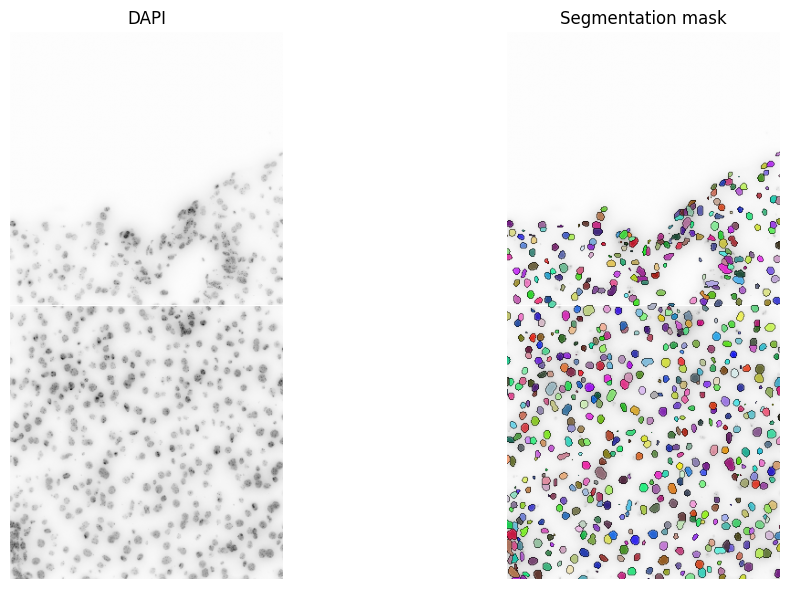

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # figsize=(10, 5))

channel = "DAPI"
# normalization parameters for visualization (underlying image not changed)

render_images_kwargs = {"cmap": "binary"}
render_labels_kwargs = {"fill_alpha": 0.6, "outline_alpha": 0.4}
show_kwargs = {
    "title": "DAPI",
    "colorbar": False,
}
_ax = hp.pl.plot_sdata(
    sdata,
    img_layer="raw_image",
    channel=0,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[0],
)
_ax.axis("off")

show_kwargs = {
    "title": "Segmentation mask",
    "colorbar": False,
}
_ax = hp.pl.plot_sdata(
    sdata,
    img_layer="raw_image",
    labels_layer="segmentation_mask",
    channel=0,
    render_images_kwargs=render_images_kwargs,
    render_labels_kwargs=render_labels_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[1],
)
_ax.axis("off")

plt.tight_layout()
plt.show()

Rechunk, so the labels layer and image layer have same spatial (('z'), 'y', 'x') chunk size.

In [4]:
# first make sure image layer and labels layer have the same chunk size
chunk_size = 1024
img_layer = "raw_image"
labels_layer = "segmentation_mask"

# rechunk
sdata = hp.im.add_image_layer(
    sdata,
    arr=hp.im.get_dataarray(sdata, layer=img_layer).data.rechunk(chunk_size),
    output_layer=img_layer,
    c_coords=["DAPI"],
    overwrite=True,
)

sdata = hp.im.add_labels_layer(
    sdata,
    arr=hp.im.get_dataarray(sdata, layer=labels_layer).data.rechunk(chunk_size),
    output_layer=labels_layer,
    overwrite=True,
)

2025-12-02 12:32:21,270 - harpy.image._manager - INFO - Writing results to layer 'raw_image'


/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/spatialdata/_core/_elements.py:71: UserWarning: Key `raw_image` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
2025-12-02 12:32:21,304 - harpy.image._manager - INFO - Writing results to layer 'segmentation_mask'
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/spatialdata/_core/_elements.py:88: UserWarning: Key `segmentation_mask` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Now, lets aggregate the image and labels layer.

In [5]:
sdata = hp.tb.allocate_intensity(
    sdata,
    img_layer="raw_image",
    labels_layer="segmentation_mask",
    output_layer="table_intensities",
    mode="sum",
    obs_stats=["var", "skew", "count"],  # count will be added as "cell_size" in .obs
    instance_size_key="cell_size",
    calculate_center_of_mass=True,
    spatial_key="spatial",
)

display(sdata["table_intensities"])
display(sdata["table_intensities"].to_df().head())
display(sdata["table_intensities"].obs.head())
display(sdata["table_intensities"].obsm["spatial"][:5])  # -> center of mask

/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


/Users/arnedf/VIB/harpy/src/harpy/utils/_aggregate.py:478: RuntimeWarning: invalid value encountered in divide
  skewness = (sum_third / count) / (np.sqrt(sum_square / count)) ** 3
2025-12-02 12:32:22,523 - harpy.utils._aggregate - WARNING - Replacing NaN values in 'skewness' with 0 for affected cells.
/Users/arnedf/VIB/harpy/src/harpy/table/_allocation_intensity.py:320: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  adata.obsm[spatial_key] = coordinates


AnnData object with n_obs × n_vars = 657 × 1
    obs: 'cell_ID', 'fov_labels', 'var_DAPI', 'skew_DAPI', 'cell_size'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

channels,DAPI
cells,
1_segmentation_mask_49e70252,1675982.0
2_segmentation_mask_49e70252,4928528.0
4_segmentation_mask_49e70252,4872624.0
5_segmentation_mask_49e70252,2925965.0
7_segmentation_mask_49e70252,2936661.0


,cell_ID,fov_labels,var_DAPI,skew_DAPI,cell_size
cells,,,,,
1_segmentation_mask_49e70252,1,segmentation_mask,801741.18750,0.000000,1063.0
2_segmentation_mask_49e70252,2,segmentation_mask,293185.37500,0.020571,2317.0
4_segmentation_mask_49e70252,4,segmentation_mask,320540.90625,0.000000,2192.0
5_segmentation_mask_49e70252,5,segmentation_mask,168423.75000,0.931227,1777.0
7_segmentation_mask_49e70252,7,segmentation_mask,461050.06250,0.161739,1417.0


array([[2125.67638758,  961.25117592],
       [2068.32887354, 1036.62926198],
       [2016.3020073 , 1052.68385036],
       [2033.00844119, 1103.77940349],
       [1748.87579393, 1120.17431193]])

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


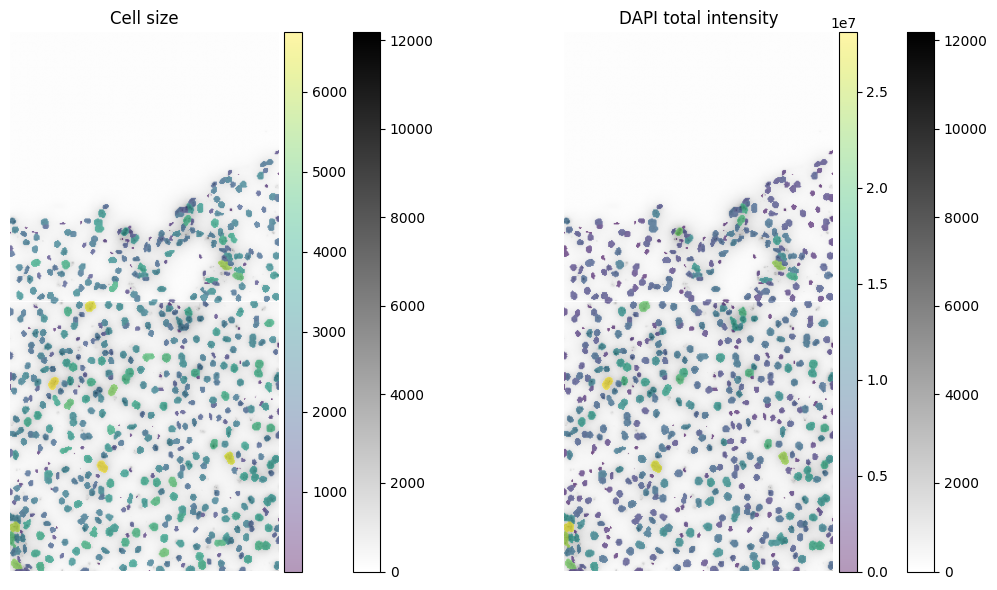

In [6]:
# visualize the info with spatialdata-plot

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# normalization parameters for visualization (underlying image not changed)
se = hp.im.get_dataarray(sdata, layer="raw_image")

channel = "DAPI"

render_images_kwargs = {"cmap": "binary"}
render_labels_kwargs = {"fill_alpha": 0.6, "outline_alpha": 0.4}

# color by area
color = "cell_size"
show_kwargs = {
    "title": "Cell size",
    "colorbar": True,
}
ax = hp.pl.plot_sdata(
    sdata,
    img_layer="raw_image",
    channel=channel,
    labels_layer="segmentation_mask",
    table_layer="table_intensities",
    color=color,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[0],
)
ax.axis("off")

# color by mean intensity
color = channel
show_kwargs = {
    "title": f"{color} total intensity",
    "colorbar": True,
}
ax = hp.pl.plot_sdata(
    sdata,
    img_layer="raw_image",
    channel=channel,
    labels_layer="segmentation_mask",
    table_layer="table_intensities",
    color=color,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[1],
)
ax.axis("off")

plt.tight_layout()
plt.show()

Note that using the `harpy.utils.RasterAggregator` class, we can also calculate the  'quantiles', 'radii' and 'principal_axes'.

In [7]:
import harpy as hp

img_array = sdata[img_layer].data[:, None, ...]
mask_array = sdata[labels_layer].data[None, ...]

aggregator = hp.utils.RasterAggregator(mask_dask_array=mask_array, image_dask_array=img_array)
df_quantiles = aggregator.aggregate_quantiles(depth=200, quantiles=[0.1, 0.3, 0.5, 0.7, 0.9])

display(df_quantiles[0].head())  # -> 0.1 quantile intensity for each cell and each channel
display(df_quantiles[-1].head())  # -> 0.9 quantile
df_radii_axes = aggregator.aggregate_radii_and_axes(depth=200, calculate_axes=False)  # raddi
display(df_radii_axes.head())

,0,cell_ID
0,0.000000,1
1,1238.000000,2
2,1370.500000,4
3,1163.199951,5
4,1191.000000,7


,0,cell_ID
0,2644.000000,1
1,2727.000000,2
2,2804.899902,4
3,2179.000000,5
4,3047.000000,7


,0,1,2,cell_ID
0,11.452508,7.496437,0.0,1
1,14.585308,12.705996,0.0,2
2,15.416794,11.370177,0.0,4
3,13.131853,10.793805,0.0,5
4,13.820557,8.377190,0.0,7


## Example 2: [Merscope data](https://info.vizgen.com/mouse-liver-data).

In [8]:
sdata = hp.datasets.merscope_mouse_liver_segmentation_mask()

/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


Back the data to a Zarr store for optimal processing.

In [9]:
import os
import tempfile
from uuid import uuid4

from spatialdata import read_zarr

sdata.write(os.path.join(tempfile.tempdir, f"sdata_{uuid4()}.zarr"))
sdata = read_zarr(sdata.path)

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside                                                                                         
         /var/folders/q5/7yhs0l6d0x771g7qdbhvkvmr0000gp/T/sdata_601cb3cf-c0f5-4bd5-b767-7a70d537d514.zarr). Please 
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /var/folders/q5/7yhs0l6d0x771g7qdbhvkvmr0000gp/T/sdata_601cb3cf-c0f5-4bd5-b767-7a70d537d514.zarr          


version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [10]:
# first make sure image layer and labels layer have the same chunk size

chunk_size = 4096  # pick a chunksize that is not too small
img_layer = "clahe"
labels_layer = "segmentation_mask_full"

# rechunk
sdata = hp.im.add_image_layer(
    sdata,
    arr=hp.im.get_dataarray(sdata, layer=img_layer).data.rechunk(chunk_size),
    output_layer=img_layer,
    c_coords=["DAPI", "PolyT"],
    scale_factors=[2, 2, 2, 2],
    overwrite=True,
)

sdata = hp.im.add_labels_layer(
    sdata,
    arr=hp.im.get_dataarray(sdata, layer=labels_layer).data.rechunk(chunk_size),
    output_layer=labels_layer,
    scale_factors=[2, 2, 2, 2],
    overwrite=True,
)

2025-12-02 12:29:41,836 - harpy.image._manager - INFO - Writing results to layer 'clahe'
version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keywor

KeyboardInterrupt: 

In [ ]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(
    n_workers=8,  # using workers instead of threads is slightly faster on large datasets.
    threads_per_worker=1,
    memory_limit="500GB",  # prevent spilling to disk
)

client = Client(cluster)
print(client.dashboard_link)

In [6]:
img_array = sdata[img_layer].data[:, None, ...]
mask_array = sdata[labels_layer].data[None, ...]

assert img_array.chunksize[-2:] == mask_array.chunksize[-2:], "Chunk size in the spatial dimension should be equal."

In [ ]:
aggregator = hp.utils.RasterAggregator(mask_dask_array=mask_array, image_dask_array=img_array)
df = aggregator.aggregate_stats(stats_funcs=("sum"))  # takes ~2min on M2 mac.

In [10]:
df[0].head()  # -> sum of intensity for each channel and for each cell

,0,1,cell_ID
0,1.271207e+12,3.169670e+12,0
1,1.255469e+07,5.063005e+07,1025
2,1.141710e+05,4.061490e+05,1026
3,1.000944e+06,7.133834e+06,1027
4,1.000245e+07,2.617968e+07,1028


In [11]:
import numpy as np

from harpy.utils._keys import _INSTANCE_KEY

# sanity check

cell_ID = 1025

assert (
    sum(sdata[img_layer].data[0, ...][sdata[labels_layer].data == cell_ID].compute().astype(np.float32))
    == df[0][df[0][_INSTANCE_KEY] == cell_ID][0].item()
)

In [12]:
client.close()